In [ ]:
%pip install datasets contractions nltk transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%cd /content/drive/MyDrive/cmu-stuff/2025-spring/14795_AI_Infosec/final_project/project_code

/content/drive/MyDrive/cmu-stuff/2025-spring/14795_AI_Infosec/final_project/project_code


In [ ]:
import functools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import string
import contractions
import seaborn as sns
import torch
import nltk

from typing import Dict, Any, Optional, List, Tuple
from transformers import pipeline
from datasets import load_dataset
from nltk.corpus import stopwords


nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
@functools.cache
def load_data():
  """
  Avoid loading the dataset every time. Only ONCE
  """
  ds = load_dataset("dmitva/human_ai_generated_text")

  df_all = ds["train"].to_pandas()
  df_all.drop(columns=["id"],inplace=True)

  # Find out the length of ai_text and human_text
  df_all["ai_text_length"] = df_all["ai_text"].str.len()
  df_all["human_text_length"] = df_all["human_text"].str.len()

  return df_all

In [ ]:
# Load the data
df = load_data()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

model_training_dataset.csv:   0%|          | 0.00/3.93G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

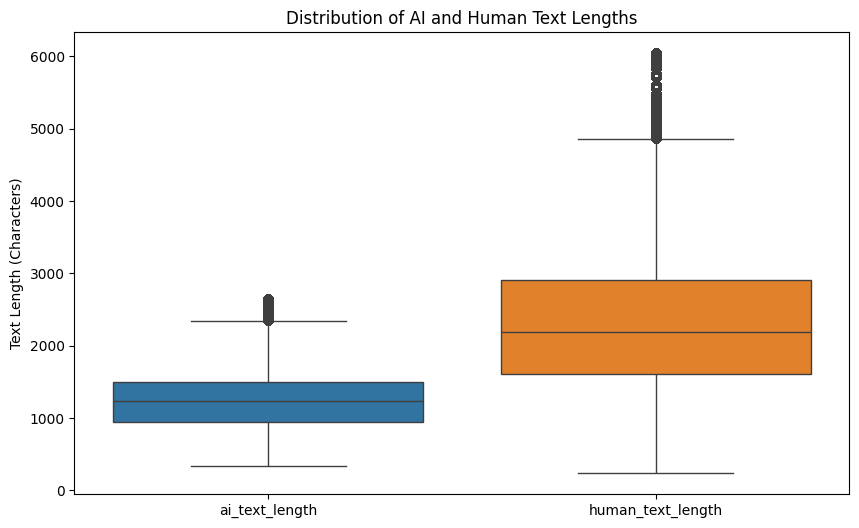

In [ ]:
# prompt: For df's ai_text_length and human_text_length, draw a whisker plot for their distributions
# Create the whisker plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['ai_text_length', 'human_text_length']])
plt.title('Distribution of AI and Human Text Lengths')
plt.ylabel('Text Length (Characters)')
plt.show()


## NLTK-based word frequency inspection

In [ ]:
from collections import defaultdict
def compute_freq(col_name: Optional[str], series_inputs : pd.Series):

  col_name = "untitled" if col_name is None else col_name

  freqs = defaultdict(int)

  puncs = set(string.punctuation)
  stopwords = set(nltk.corpus.stopwords.words("english"))
  bad_tokens = {*stopwords, *puncs}

  for idx, comment in enumerate(series_inputs):
      print(f"\r[{col_name}]PROGRESS: {idx + 1} / {len(series_inputs)}", end="")

      word_tokens = nltk.word_tokenize(comment)
      filtered_sentence = [w for w in word_tokens if w not in bad_tokens]

      for word in filtered_sentence:
          if word not in freqs:
              freqs[word] = 1
          else:
              freqs[word] += 1

  # Also look at the words for expressing emotions
  pos_dict = dict(nltk.pos_tag(list(freqs.keys()), tagset="universal"))

  # now let's look at those words that can potentially suggset feelings, in this case they are adjectives, adverbs, and conjunctions
  emote_word_freqs = {
      k: v for k, v in freqs.items() if pos_dict[k] in ["ADJ", "ADV", "CONJ"]
  }

  print("\nAll Done.")


  return (dict(sorted(freqs.items(), key=lambda item: item[1], reverse=True)),
          dict(sorted(emote_word_freqs.items(), key=lambda item: item[1], reverse=True)),)

def visualize_freq(col_name: Optional[str], freqs : Dict[str,int], emote_freqs: Dict[str,int]):

  col_name = "untitled" if col_name is None else col_name

  top_n = 50
  top_words = list(freqs.keys())[:top_n]
  top_counts = list(freqs.values())[:top_n]

  top_emo_words = list(emote_freqs.keys())[:top_n]
  top_emo_counts = list(emote_freqs.values())[:top_n]

  plt.figure(figsize=(top_n / 4, 3))
  plt.bar(top_words, top_counts, align="center")
  plt.xticks(rotation=90)
  plt.title(f"[{col_name}]Frequencies of top {top_n} words")

  plt.show()

  plt.figure(figsize=(top_n / 4, 3))
  plt.bar(top_emo_words, top_emo_counts, align="center")
  plt.xticks(rotation=90)
  plt.title(f"[{col_name}]Frequencies of top {top_n} EMOTIONAL words")

  plt.show()


def analyze(col_name: Optional[str], series_inputs : pd.Series):
  freqs, emote_freqs = compute_freq(col_name, series_inputs)
  visualize_freq(col_name, freqs, emote_freqs)

  return (freqs, emote_freqs,)


In [ ]:
df_sample = df.sample(10000)

[ai_text]PROGRESS: 10000 / 10000
All Done.


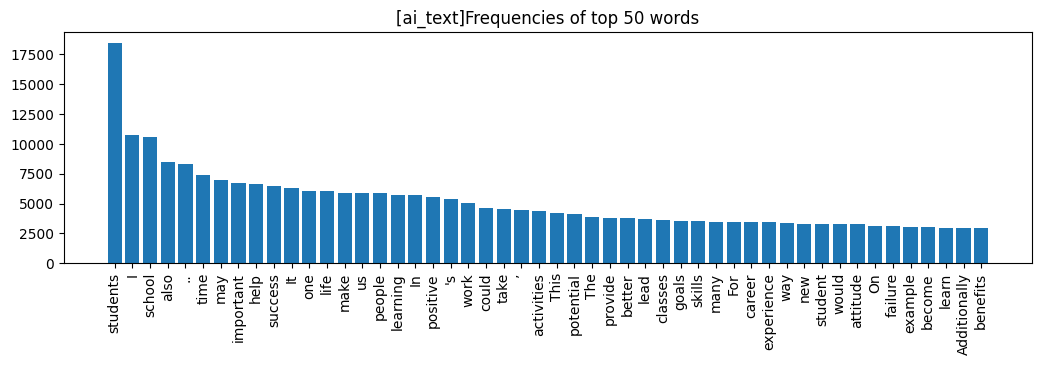

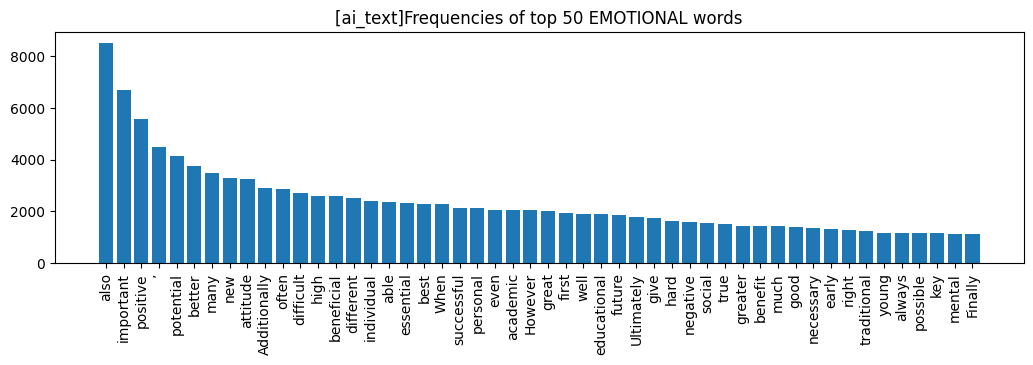

[human_text]PROGRESS: 10000 / 10000
All Done.


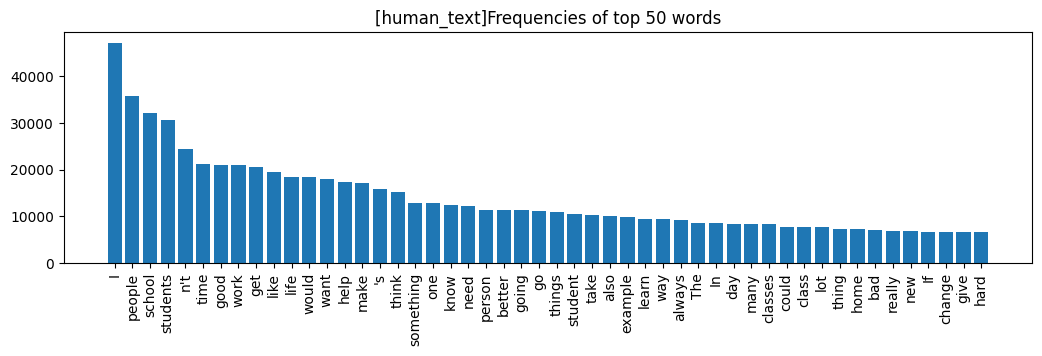

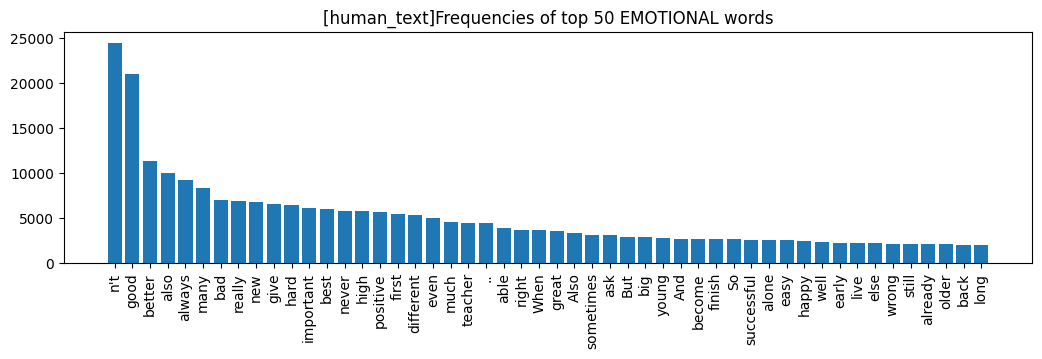

In [ ]:
freq_mp = {}

for col in ["ai_text", "human_text"]:
    freqs, emote_freqs = analyze(col, df_sample[col])

    freq_mp[col] = {
        "normal" : freqs,
        "emote" : emote_freqs
    }

In [ ]:
classifier = pipeline(
    "zero-shot-classification", model="facebook/bart-large-mnli", device_map="auto"
)

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
def clean_word(input_word: str):

  puncs = set(string.punctuation)

  ret = copy.deepcopy(input_word)

  for p in puncs:

    ret = ret.replace(p,'')

  return ret.strip().lower()


def filter_short(words: List[str]):

  return list(set([clean_word(w) for w in words if len(clean_word(w)) > 1]))

ai_tags = filter_short(freq_mp["ai_text"]["emote"])[:30]
human_tags = filter_short(freq_mp["human_text"]["emote"])[:30]

combined_tags = list(sorted(set(ai_tags + human_tags)))[:30]

In [ ]:
# Export the dataset for tagging
# Split right now
df_train = df.sample(frac=0.8, random_state=114514)
df_test = df.drop(df_train.index)

df_train.to_csv("train.csv", index=False)
df_test.to_csv("test.csv", index=False)


In [ ]:
df_small = df.sample(50000)

df_small.to_csv("data_50k.csv")